In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
import importlib

In [2]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_370.pth"

In [3]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }


Using device: cuda
Channels : 24


In [4]:
importlib.reload(score)
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = score.ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = score.VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_3873086/1812132184.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_370.pth, trained until epoch 370


In [5]:
for batch, dic in testloader:
    t = torch.rand(batch.shape[0], dtype=batch.dtype)
    t[0] = 0.8
    t[1] = 0.9
    t[2] = 1
    c = dic["context"]
    c = c.to(device)
    batch = batch.to(device)
    t = t.to(device)
    x_t = vpsde.forward(batch, t , train=False)
    x_0 = vpsde.denoise(x_t,t,c)
    print(vpsde.mu(t[:3]))
    print(vpsde.sigma(t[:3]))
    break

tensor([0.1313, 0.0480, 0.0050], device='cuda:0')
tensor([0.9914, 0.9989, 1.0000], device='cuda:0')


<h1> Display Batch </h1>

torch.Size([48, 24, 64, 64])
T2m  Mean : 12.64405345916748, Var: 1.299829363822937
U10m  Mean : 3.3048784732818604, Var: 1.0086430311203003
T2m  Mean : 8.436080932617188, Var: 1.096491813659668
U10m  Mean : 4.4069600105285645, Var: 1.4603081941604614
T2m  Mean : 5.0110554695129395, Var: 1.2796790599822998
U10m  Mean : 3.7615773677825928, Var: 1.1854467391967773
T2m  Mean : 4.570932865142822, Var: 1.1732854843139648
U10m  Mean : 5.707757472991943, Var: 2.275991678237915
T2m  Mean : 21.697765350341797, Var: 2.035621166229248
U10m  Mean : 3.3037686347961426, Var: 1.4090447425842285


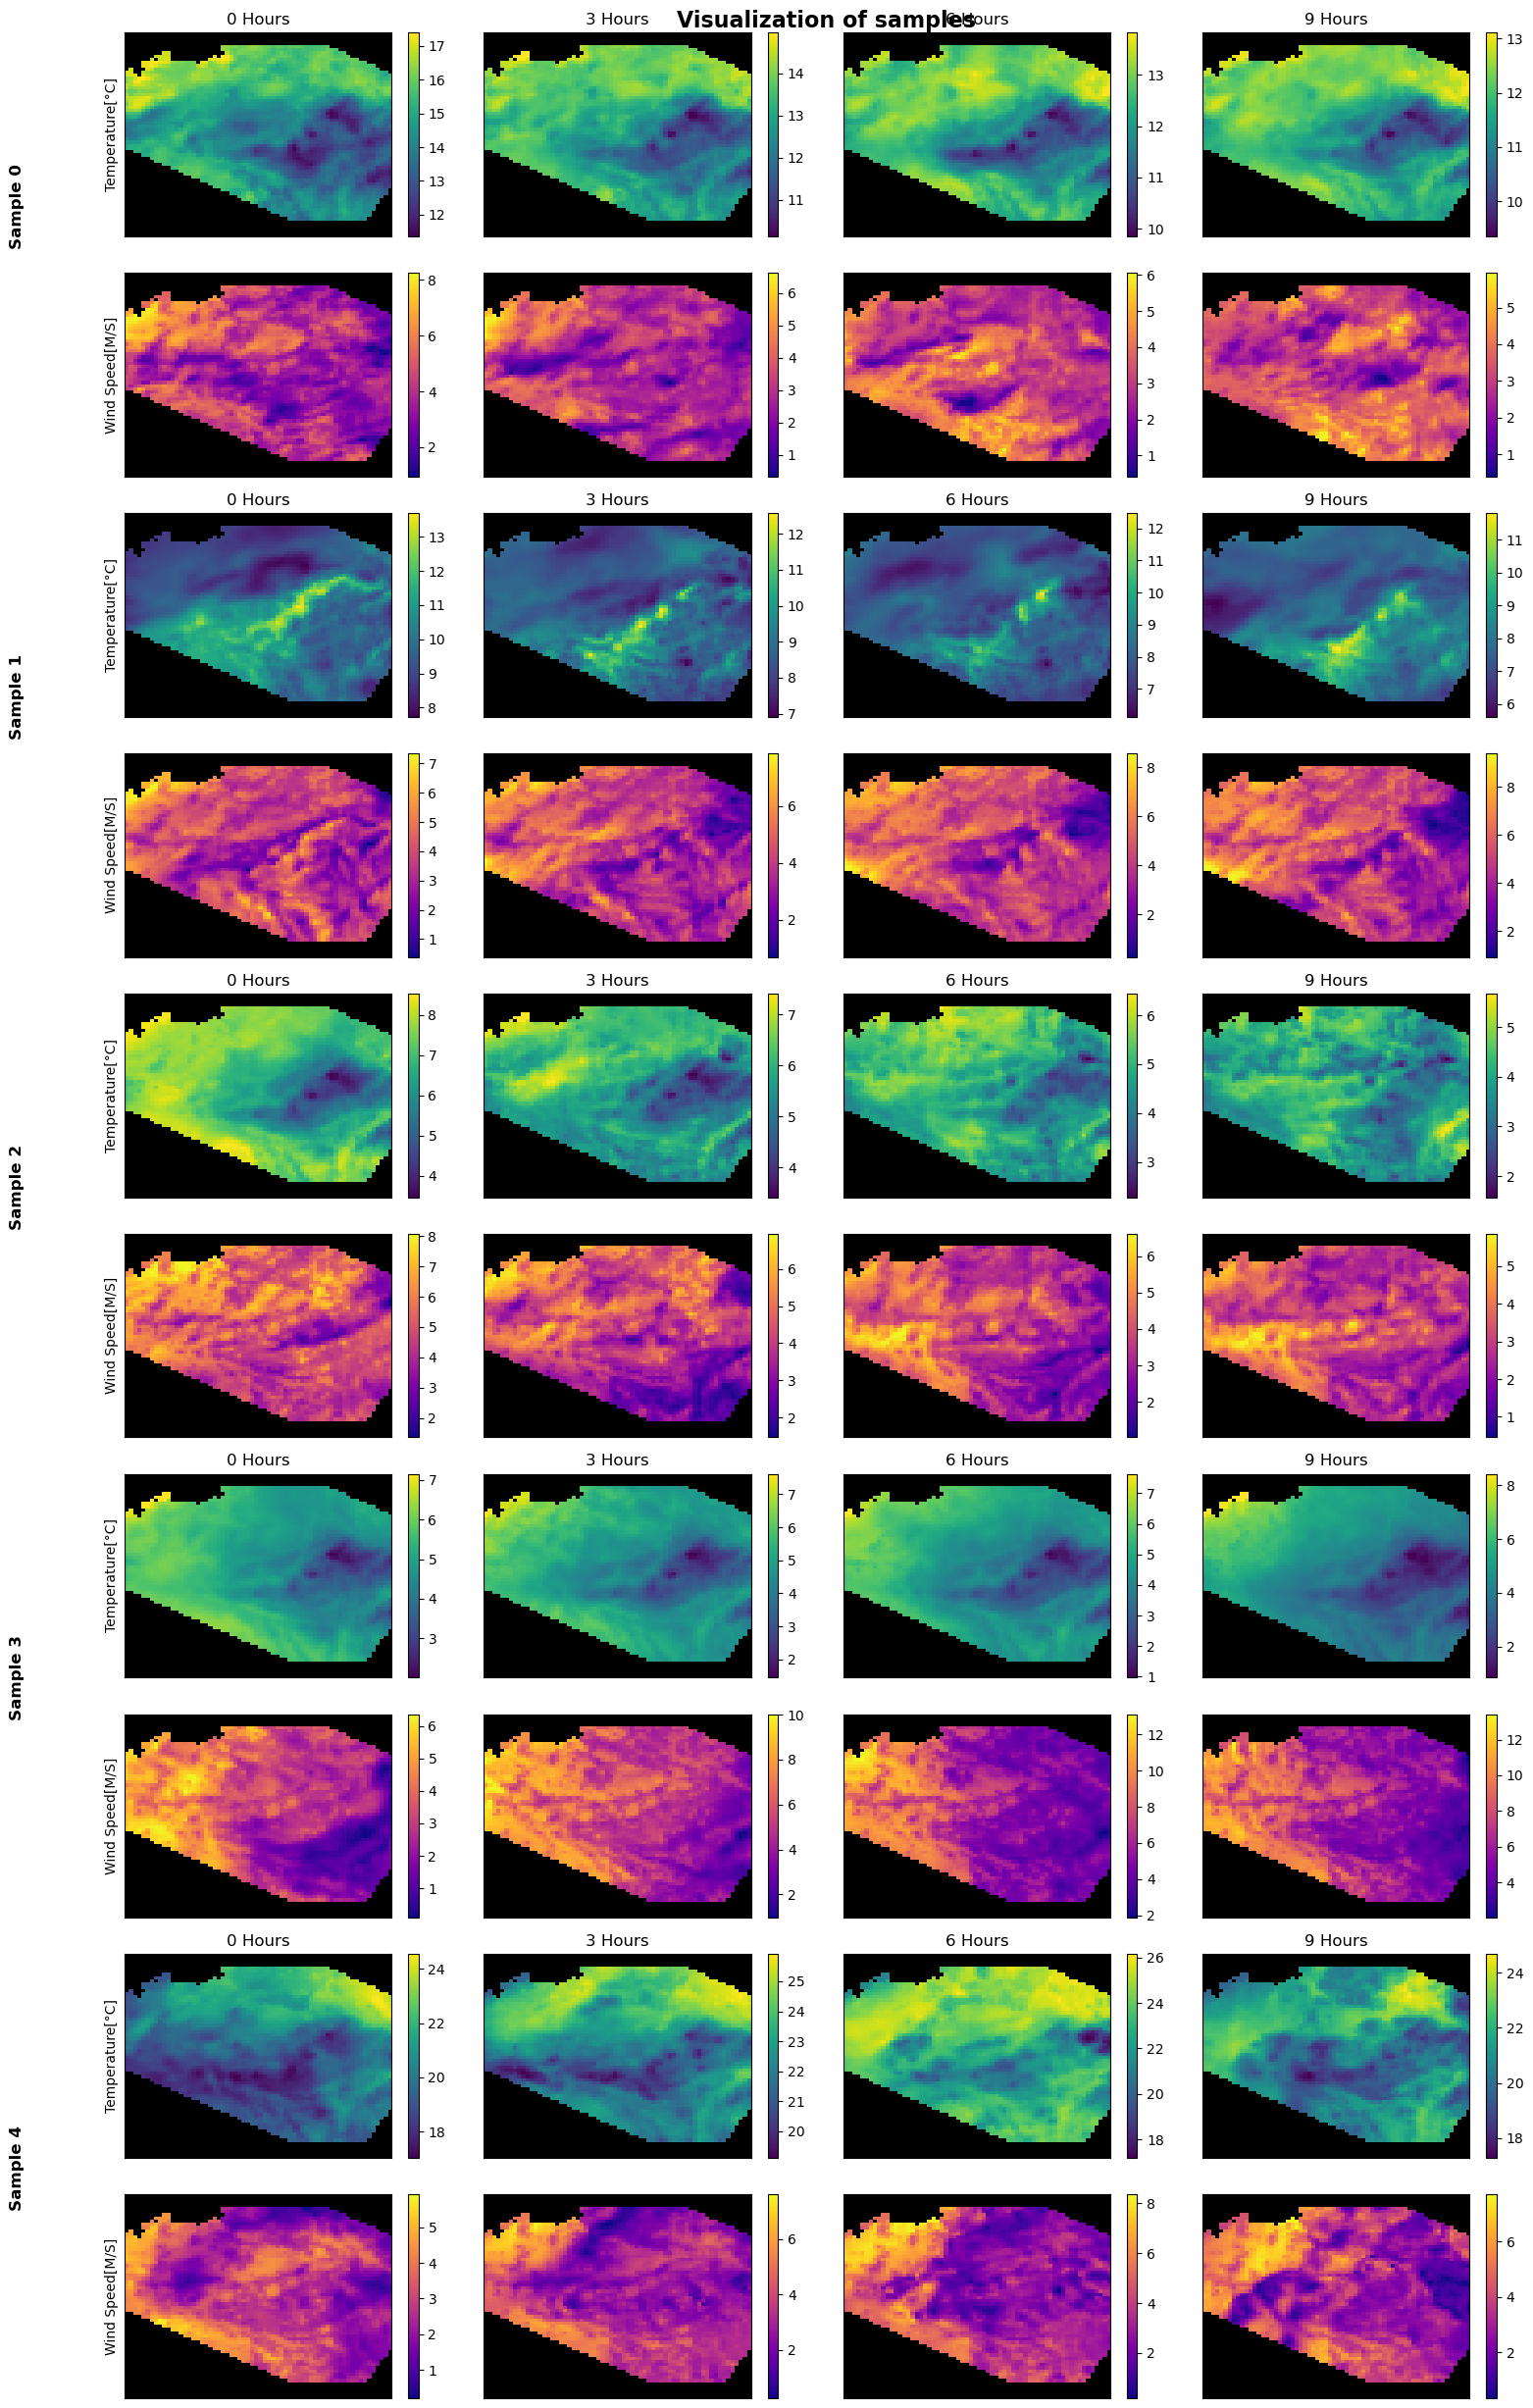

In [7]:
from utils import plot_sample
PATH = Path('.')
path_unnorm = PATH / "data/processed/train.h5"
info = {'var_index': ['T2m', 'U10m'], 'channels': 2, 'window': 12}

batch_cpu = batch.detach().cpu()
fig = plot_sample(batch_cpu, info, mask_cpu, samples=5, step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1> Load and Plot Samples</h1>

In [90]:
# Load Samples
c = c.to(torch.float32).to(device)
c = c.repeat(10,1,1,1)

sample = vpsde.sample(mask,c=c[:100],shape=(100,),steps=2, corrections=0)
#sample = vpsde.ddpm_sample(mask,shape=(8,),c=c[:8],steps=10)

hello


100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.21it/s]


torch.Size([100, 24, 64, 64])
T2m  Mean : 4.560128688812256, Var: 8.224189758300781
U10m  Mean : 3.38179349899292, Var: 5.024036884307861
T2m  Mean : 10.419930458068848, Var: 6.992278099060059
U10m  Mean : 6.285784721374512, Var: 4.139181137084961
T2m  Mean : 18.83480453491211, Var: 6.826106071472168
U10m  Mean : 3.765591859817505, Var: 3.6853268146514893
T2m  Mean : 2.0616188049316406, Var: 8.444151878356934
U10m  Mean : 3.33394193649292, Var: 4.315666675567627
T2m  Mean : 12.781108856201172, Var: 6.090561866760254
U10m  Mean : 4.259841442108154, Var: 4.745919227600098
T2m  Mean : 15.283341407775879, Var: 6.297776222229004
U10m  Mean : 2.53993821144104, Var: 4.16684627532959
T2m  Mean : 18.394451141357422, Var: 6.329493045806885
U10m  Mean : 5.056765556335449, Var: 3.8999183177948
T2m  Mean : 8.868439674377441, Var: 8.674484252929688
U10m  Mean : 1.8693270683288574, Var: 3.6064164638519287


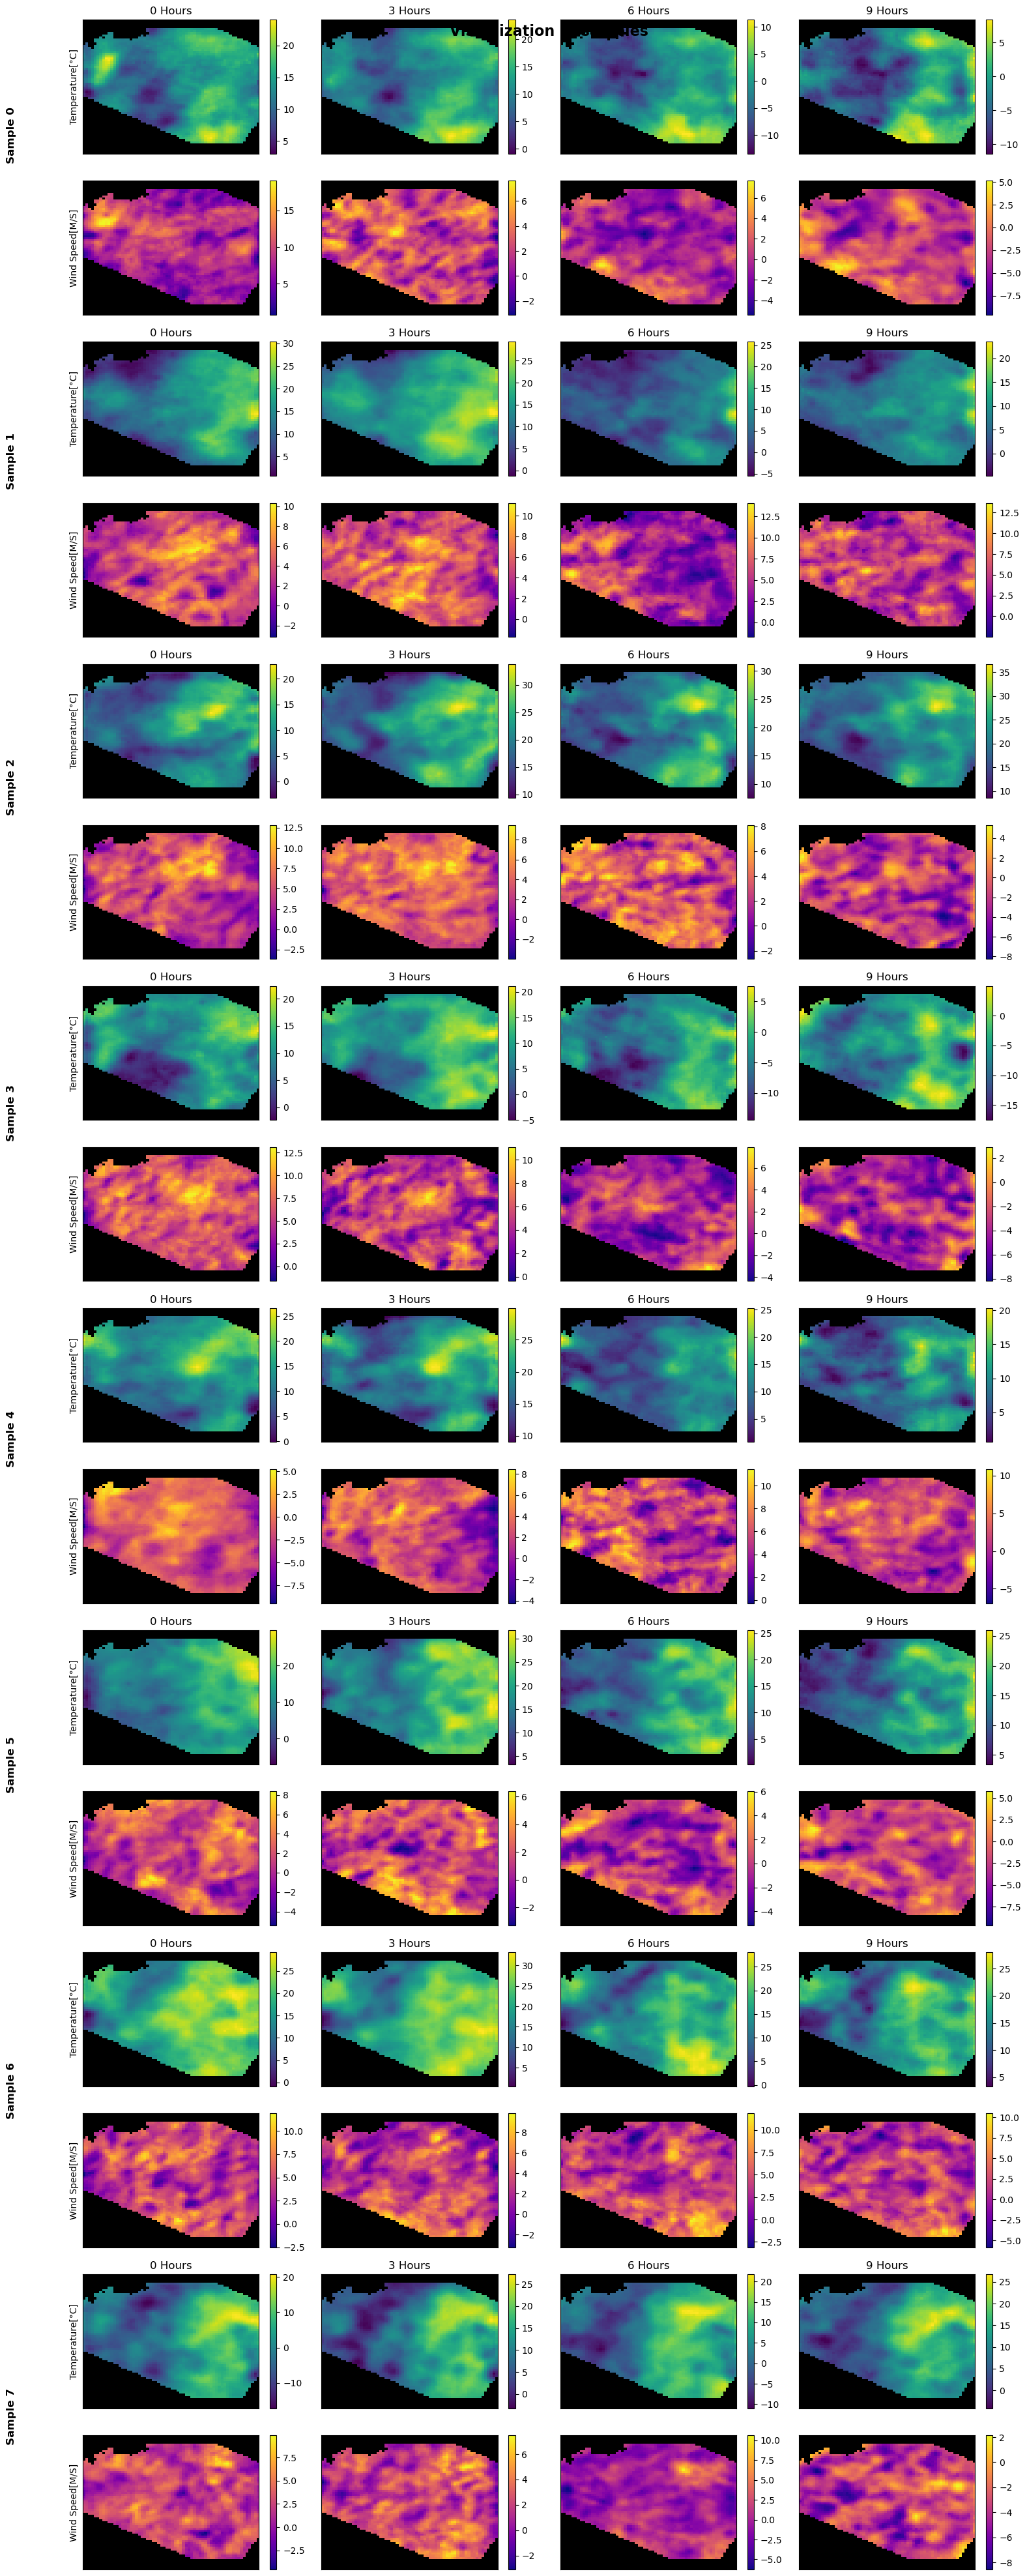

In [91]:
sample_cpu = sample.detach().cpu()
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sample_cpu,info,mask_cpu,samples=8,step=3, unnormalize=True, path_unnorm = path_unnorm)

<h1>Plot : Batch, Noised Batch and Unnoising of Noised Batch</h1>

torch.Size([144, 24, 64, 64])
T2m  Mean : 12.64405345916748, Var: 1.299829363822937
U10m  Mean : 3.3048784732818604, Var: 1.0086430311203003
T2m  Mean : 10.65589714050293, Var: 7.273653984069824
U10m  Mean : 3.9200503826141357, Var: 2.1111133098602295
T2m  Mean : 12.491242408752441, Var: 1.2290167808532715
U10m  Mean : 3.298924446105957, Var: 0.7148923277854919
T2m  Mean : 8.436080932617188, Var: 1.096491813659668
U10m  Mean : 4.4069600105285645, Var: 1.4603081941604614
T2m  Mean : 10.376242637634277, Var: 7.321969032287598
U10m  Mean : 4.014598846435547, Var: 2.1362600326538086
T2m  Mean : 10.341277122497559, Var: 1.7324141263961792
U10m  Mean : 4.096883773803711, Var: 1.206703543663025
T2m  Mean : 5.0110554695129395, Var: 1.2796790599822998
U10m  Mean : 3.7615773677825928, Var: 1.1854467391967773
T2m  Mean : 10.373820304870605, Var: 7.298419952392578
U10m  Mean : 4.017990589141846, Var: 2.1389641761779785
T2m  Mean : 11.335916519165039, Var: 15.515536308288574
U10m  Mean : 6.08712291

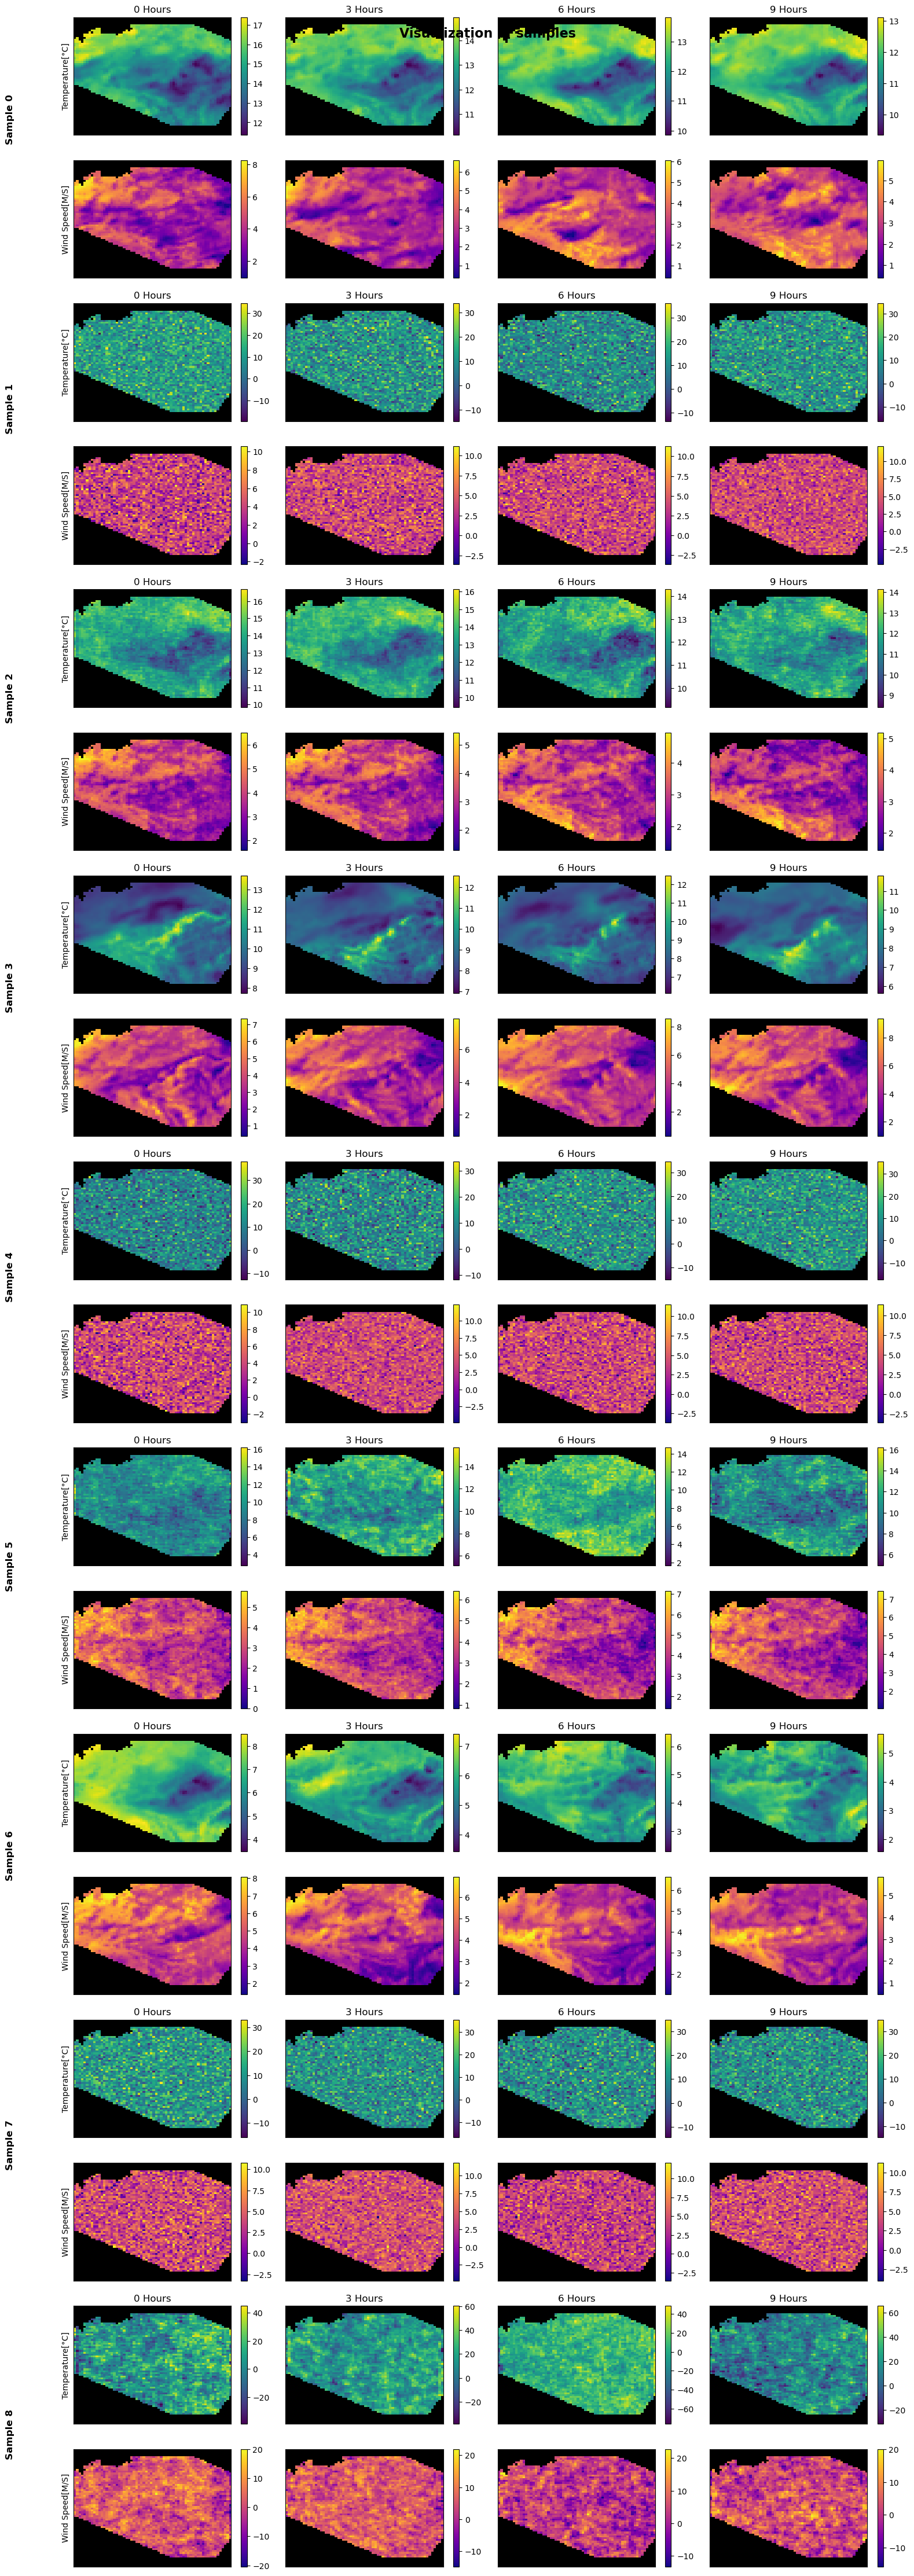

In [8]:
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
new_tensor = torch.stack((batch,x_t,x_0), dim=1).flatten(0,1).detach().cpu()

fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [92]:
from TFE.metric.model import *
efficient_net = EfficientNet()
checkpoint_eff_path = 'efficientnet_finetuned.pth'
checkpoint = torch.load(checkpoint_eff_path, map_location='cpu', weights_only=True)
efficient_net.load_state_dict(checkpoint)
label = ['p(x)','samples']

In [93]:
efficient_net.eval()
with torch.no_grad():
    output = efficient_net(sample.cpu()[:100])
    prob = torch.nn.functional.softmax(output, dim = 1)
    _, preds = torch.max(output, 1)
    print(preds)
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100} %")

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 99.99952697753906 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 99.9995346069336 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 100.0 %
samples with 99.99959564208

tensor([[1.0775e-05, 9.9999e-01],
        [5.4763e-07, 1.0000e+00],
        [1.1544e-06, 1.0000e+00],
        [2.8063e-06, 1.0000e+00],
        [1.4763e-06, 1.0000e+00],
        [1.9036e-05, 9.9998e-01],
        [2.3095e-05, 9.9998e-01],
        [1.3038e-04, 9.9987e-01]])


In [94]:
with torch.no_grad():
    output = efficient_net(batch.cpu()[:100])
    prob = torch.nn.functional.softmax(output, dim = 1)
    _, preds = torch.max(output, 1)
    for i in range(len(preds)):
        print(f"{label[preds[i]]} with {prob[i,preds[i]]*100} \%")

p(x) with 99.94145965576172 \%
p(x) with 99.46356201171875 \%
p(x) with 97.34785461425781 \%
samples with 55.83549880981445 \%
p(x) with 99.34507751464844 \%
p(x) with 99.86729431152344 \%
p(x) with 100.0 \%
p(x) with 98.04373168945312 \%
p(x) with 73.75269317626953 \%
samples with 98.62653350830078 \%
samples with 99.93241119384766 \%
p(x) with 99.97547149658203 \%
samples with 65.30536651611328 \%
samples with 99.828857421875 \%
p(x) with 99.90906524658203 \%
p(x) with 98.6140365600586 \%
p(x) with 99.37802124023438 \%
samples with 99.98750305175781 \%
p(x) with 97.00108337402344 \%
p(x) with 99.99606323242188 \%
p(x) with 99.99685668945312 \%
p(x) with 99.96532440185547 \%
p(x) with 100.0 \%
p(x) with 97.98615264892578 \%
p(x) with 98.46028137207031 \%
p(x) with 99.9948501586914 \%
p(x) with 99.8854751586914 \%
p(x) with 99.7090072631836 \%
samples with 54.43724822998047 \%
p(x) with 99.99775695800781 \%
p(x) with 99.94345092773438 \%
p(x) with 99.94548034667969 \%
p(x) with 99.9986

In [ ]:
from TFE.utils import *
process_file = Path('data/processed/train.h5')
samples_file = Path('generated_samples.h5')

process_dataset =  SequenceDataset(file=process_file, window=12, flatten=True, slicer=slice(3000))
samples_dataset = BatchDataset(file=samples_file, data_keyword='samples')
print(len(process_dataset))
print(len(samples_dataset))